In [9]:
import numpy as np
import pandas as pd
import gzip
import pickle
from collections import Counter
from utils import split_all_data
from scipy.stats import skew, kurtosis

import re
import spacy
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

In [11]:
RANDOM_SEED = 1835

In [14]:
data_dict = split_all_data(.8, random_state=RANDOM_SEED)
train_df = data_dict['train']

Loading the data...
Splitting the data...


### Section 1 Tokenizer and Stemming functions

#### 1.1 Definition

In [12]:
spacy_model = spacy.load('en_core_web_lg')

def spacy_tokenizer(text):
    sp_text = spacy_model(text)
    tokens = [token.lemma_ for token in sp_text if (not token.is_stop and token.is_alpha)]
    return tokens

In [13]:
stop_words = stopwords.words('english')

stemmer = PorterStemmer()
def stem_token(text):
    tokens = [stemmer.stem(word) for word in re.findall(r'\w\w+', text) if word not in stop_words]
    return tokens

#### 1.2 Speed Comparison

In [15]:
%%timeit
spacy_tokenizer(train_df['tweet'].iloc[10][0])

9.52 ms ± 329 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
%%timeit
stem_token(train_df['tweet'].iloc[10][0])

471 µs ± 5.08 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


#### 1.3 Output Comparison

In [17]:
# testing the tokenizer/lemmatizer
for item in train_df.sample(10, random_state=RANDOM_SEED).itertuples():
    if item[3] is not None:
        tokenized_s = stem_token(item[3][0])
        tokenized_l = spacy_tokenizer(item[3][0])
        count_stem = Counter(tokenized_s)
        count_lemm = Counter(tokenized_l)
        print(f'user: {item[1]} - label: {item[-1]}\n', 'Stemming:     ', count_stem.most_common(10), '\n', 'Lemmatization:', count_lemm.most_common(10), '\n')
    else:
        pass

user: 1290597237991575552 - label: 1
 Stemming:      [('no', 1), ('question', 1), ('de', 1), ('jong', 1), ('bloke', 1), ('worst', 1), ('striker', 1), ('ever', 1), ('seen', 1), ('life', 1)] 
 Lemmatization: [('question', 1), ('De', 1), ('Jong', 1), ('bloke', 1), ('bad', 1), ('striker', 1), ('see', 1), ('life', 1), ('score', 1), ('winner', 1)] 

user: 159535879 - label: 0
 Stemming:      [('rt', 1), ('sadwrit', 1), ('http', 1), ('co', 1), ('ibdvhk7ayt', 1)] 
 Lemmatization: [('RT', 1)] 

user: 22189352 - label: 0
 Stemming:      [('fire', 2), ('final', 1), ('no', 1), ('injuri', 1), ('ff', 1), ('civilian', 1), ('occup', 1), ('displac', 1), ('due', 1), ('caus', 1)] 
 Lemmatization: [('fire', 2), ('FINAL', 1), ('injury', 1), ('FF', 1), ('civilian', 1), ('occupant', 1), ('displace', 1), ('cause', 1), ('investigation', 1)] 

user: 2637583066 - label: 1
 Stemming:      [('5g06021008', 1), ('efiaodo1', 1), ('you', 1), ('right', 1), ('lol', 1), ('swear', 1)] 
 Lemmatization: [('right', 1), ('lol

### Section 2 Topic Extraction

#### 2.1 Definition

In [27]:
def extract_topic_feature(row, components=None, tokenizer=None, random_state=None):
    if components is None:
        components = len(row)
    if row is not None and components > 1:
        tweets = np.array(row)

        vectorize = TfidfVectorizer(tokenizer=tokenizer, 
                                    ngram_range=(1, 2),
                                    stop_words=None if tokenizer is not None else 'english',
                                    min_df=1)
        nmf_model = NMF(n_components=components, 
                        init='nndsvd', 
                        max_iter=200, 
                        random_state=random_state)

        
        nmf_pipe = make_pipeline(vectorize, nmf_model)
        
        try:
            W = nmf_pipe.fit_transform(tweets)
        except ValueError:
            return np.nan
        
        index_max = []
        for index in range(W.shape[0]):
            max_val_index = np.argmax(W[index])
            index_max.append(max_val_index)
        
        index_norm = np.array(index_max) / components
        
        return index_norm
    else:
        return np.nan

In [28]:
# unweighted gini coefficient measure taken from https://stackoverflow.com/questions/48999542/more-efficient-weighted-gini-coefficient-in-python by user Gaëtan de Menten
def gini(x):
    sorted_x = np.sort(x)
    n = len(x)
    cumx = np.cumsum(sorted_x, dtype=float)
    return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n

#### 2.2 Testing with different preprocessing

ID: 1290597237991575552 - Label 1 - number of tweets 17


,only stopword removal,with stemming,with lemmatization
skewness,0.0,0.0,0.052751
kurtosis,-1.208333,-1.208333,-1.258479
standard deviation,0.288175,0.288175,0.282807
gini coefficient,0.352941,0.352941,0.392157


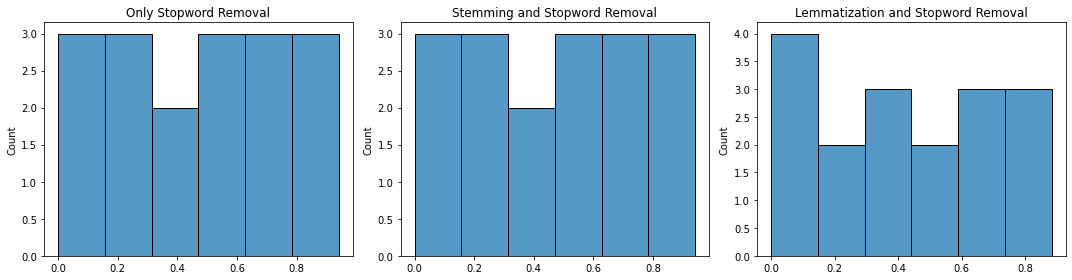

ID: 159535879 - Label 0 - number of tweets 194


,only stopword removal,with stemming,with lemmatization
skewness,-0.007642,0.00222,0.057983
kurtosis,-1.259029,-1.225339,-1.273864
standard deviation,0.293919,0.291832,0.287005
gini coefficient,0.344574,0.341308,0.391758


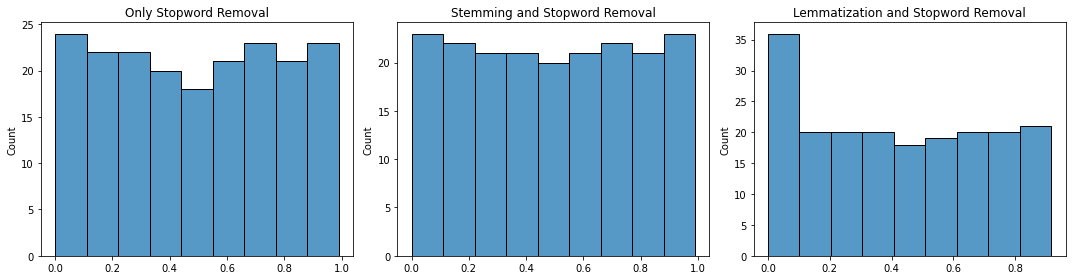

ID: 22189352 - Label 0 - number of tweets 200


,only stopword removal,with stemming,with lemmatization
skewness,-0.029362,-0.026835,-0.027499
kurtosis,-1.240969,-1.199751,-1.227342
standard deviation,0.293502,0.290632,0.291638
gini coefficient,0.338383,0.335632,0.34392


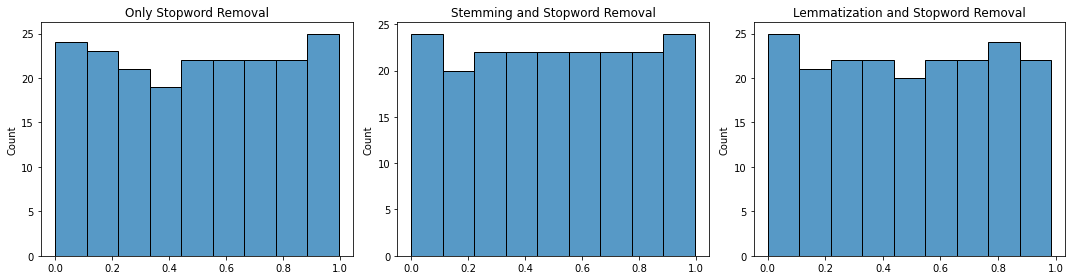

ID: 2637583066 - Label 1 - number of tweets 200


,only stopword removal,with stemming,with lemmatization
skewness,0.01679,-0.010538,0.167291
kurtosis,-1.250139,-1.201787,-1.340884
standard deviation,0.290197,0.288983,0.269467
gini coefficient,0.35143,0.347107,0.444668


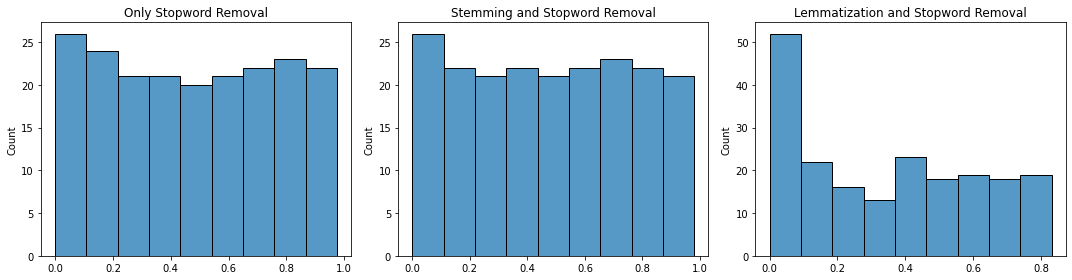

ID: 979469572494495744 - Label 0 - number of tweets 200


,only stopword removal,with stemming,with lemmatization
skewness,0.012655,-0.008298,0.01279
kurtosis,-1.216111,-1.229948,-1.260009
standard deviation,0.290481,0.294643,0.29078
gini coefficient,0.344329,0.35044,0.363775


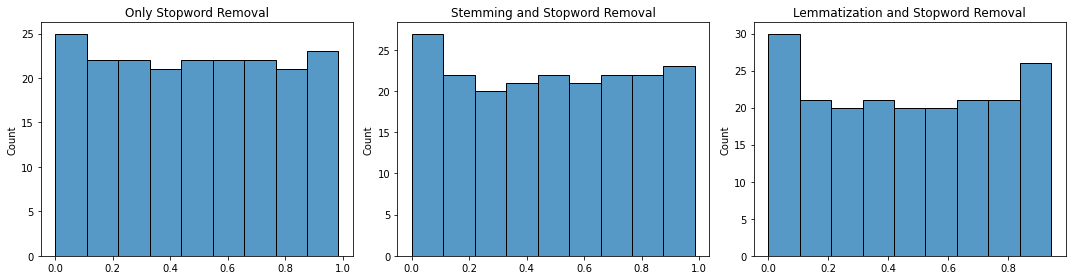

In [29]:


for row in train_df.sample(5, random_state=RANDOM_SEED).itertuples():
    print(f"ID: {row[1]} - Label {row[-1]} - number of tweets {len(row[3])}")
    ind0 = extract_topic_feature(row[3])
    ind1 = extract_topic_feature(row[3], tokenizer=stem_token)
    ind2 = extract_topic_feature(row[3], tokenizer=spacy_tokenizer)
    temp_df = pd.DataFrame(index=['skewness', 'kurtosis', 'standard deviation', 'gini coefficient'], columns=['only stopword removal', 'with stemming', 'with lemmatization'])

    temp_df.loc['skewness', 'only stopword removal'] = skew(ind0)
    temp_df.loc['skewness', 'with stemming'] = skew(ind1)
    temp_df.loc['skewness', 'with lemmatization'] = skew(ind2)
    

    temp_df.loc['kurtosis', 'only stopword removal'] = kurtosis(ind0)
    temp_df.loc['kurtosis', 'with stemming'] = kurtosis(ind1)
    temp_df.loc['kurtosis', 'with lemmatization'] = kurtosis(ind2)

    temp_df.loc['standard deviation', 'only stopword removal'] = ind0.std()
    temp_df.loc['standard deviation', 'with stemming'] = ind1.std()
    temp_df.loc['standard deviation', 'with lemmatization'] = ind2.std()

    temp_df.loc['gini coefficient', 'only stopword removal'] = gini(ind0)
    temp_df.loc['gini coefficient', 'with stemming'] = gini(ind1)
    temp_df.loc['gini coefficient', 'with lemmatization'] = gini(ind2)
    
    display(temp_df)

    fig, ax = plt.subplots(1, 3, figsize=(15, 4))
    
    sns.histplot(ind0, ax=ax[0])
    ax[0].set_title('Only Stopword Removal')
    sns.histplot(ind1, ax=ax[1])
    ax[1].set_title('Stemming and Stopword Removal')
    sns.histplot(ind2, ax=ax[2])
    ax[2].set_title('Lemmatization and Stopword Removal')


    plt.tight_layout()
    plt.show()

In [30]:
def extract_nmf_feature(df, tokenizer=spacy_tokenizer):
    df.loc[:, 'topic_dist'] = df['tweet'].apply(lambda x: extract_topic_feature(x, tokenizer=tokenizer) if x is not None else np.nan)
    df.loc[:, 'topic_skew'] = df['topic_dist'].apply(lambda x: skew(x) if x is not None else np.nan)
    df.loc[:, 'topic_kurtosis'] = df['topic_dist'].apply(lambda x: kurtosis(x) if x is not None else np.nan)
    df.loc[:, 'topic_gini'] = df['topic_dist'].apply(lambda x: gini(x) if x is not None else np.nan)
    df.loc[:, 'topic_std'] = df['topic_dist'].apply(lambda x: x.std() if x is not None else np.nan)
    return df

In [31]:
%%time
with_topic_feat = extract_nmf_feature(train_df.sample(10, random_state=RANDOM_SEED))

CPU times: user 2min 2s, sys: 1.48 s, total: 2min 3s
Wall time: 1min 12s


In [33]:
with_topic_feat[['topic_dist', 'topic_skew', 'topic_kurtosis', 'topic_gini', 'topic_std', 'label']]

,topic_dist,topic_skew,topic_kurtosis,topic_gini,topic_std,label
10139,"[0.29411764705882354, 0.5294117647058824, 0.0,...",0.052751,-1.258479,0.392157,0.282807,1
4587,"[0.0, 0.3865979381443299, 0.28865979381443296,...",0.057983,-1.273864,0.391758,0.287005,0
11274,"[0.885, 0.2, 0.71, 0.46, 0.69, 0.16, 0.015, 0....",-0.027499,-1.227342,0.343920,0.291638,0
1244,"[0.745, 0.495, 0.0, 0.735, 0.44, 0.76, 0.195, ...",0.177621,-1.257072,0.437329,0.259259,1
3949,"[0.81, 0.045, 0.72, 0.295, 0.235, 0.51, 0.42, ...",0.012790,-1.260009,0.363775,0.290780,0
7742,"[0.24873096446700507, 0.7563451776649747, 0.20...",0.018922,-1.256970,0.374283,0.290281,0
2018,"[0.4722222222222222, 0.5972222222222222, 0.305...",0.046790,-1.259306,0.360022,0.294099,1
2682,"[0.10326086956521739, 0.3695652173913043, 0.45...",-0.012183,-1.261727,0.376204,0.290294,0
9994,"[0.57, 0.235, 0.75, 0.18, 0.165, 0.33, 0.255, ...",-0.001710,-1.221276,0.358066,0.287109,1
10884,"[0.71, 0.635, 0.145, 0.405, 0.305, 0.865, 0.37...",0.047655,-1.279813,0.374453,0.290650,0
